In [1]:
import json

import torch
import torch.nn as nn

import torch.utils.data
from torch.utils.data import DataLoader, ConcatDataset

from encoder import Encoder
from custom_dataset import ContrastiveLearningDataset
from custom_loss import contrastive_loss
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

config = json.load(open('config.json', 'r'))["SSL"]

In [2]:
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Encoder()
model = model.to(device)
optimizer = SGD(model.parameters(), lr=config["start lr"])
scheduler = StepLR(optimizer, step_size=config["lr scheduler step size"], gamma=0.1)
dataset = []
for i in range(1, 4):
	if config[f"dataset {i}"] is not None:
		dataset.append(ContrastiveLearningDataset(img_dir=config[f"dataset {i}"]))
dataset = ConcatDataset(dataset)
train_dataloader = DataLoader(dataset, batch_size=config["Batch size"], shuffle=True)

In [3]:
torch.manual_seed(0)
epochs = config["epoch size"]
step = 0
steps = []
loss_list = []

for epoch in range(epochs):
    batch_loss = 0
    for i, batch in enumerate(train_dataloader):
        original, augmented = batch['original'], batch['augmented']
        original = original.to(device)
        augmented = augmented.to(device)

        optimizer.zero_grad()

        original_embeddings, _ = model(original)
        augmented_embeddings, _ = model(augmented)
        
        avg_pool = nn.AdaptiveAvgPool2d((5, original_embeddings.shape[2]))

        original_embeddings = avg_pool(original_embeddings)
        augmented_embeddings = avg_pool(augmented_embeddings)

        original_embeddings = original_embeddings.view(original_embeddings.shape[0] // 4, original_embeddings.shape[1] * 4, original_embeddings.shape[2])
        augmented_embeddings = augmented_embeddings.view(augmented_embeddings.shape[0] // 4, augmented_embeddings.shape[1] * 4, augmented_embeddings.shape[2])

        # flattened_original = original_embeddings.reshape(original_embeddings.shape[0] * original_embeddings.shape[1], -1)
        # flattened_augmented = augmented_embeddings.reshape(original_embeddings.shape[0] * original_embeddings.shape[1], -1)

        # loss = contrastive_loss(flattened_original, flattened_augmented)
        loss = contrastive_loss(original_embeddings, augmented_embeddings)
        batch_loss += loss.item()
        if i % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i + 1}/{len(train_dataloader)}, Loss:{loss.item()}")
            step += 100
            steps.append(step)
            loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch + 1}/{epochs}, Average Loss:{batch_loss / len(train_dataloader)}")

Epoch 1/3, Batch 1/26360, Loss:5.80739164352417
Epoch 1/3, Batch 101/26360, Loss:5.055341720581055
Epoch 1/3, Batch 201/26360, Loss:4.2490234375
Epoch 1/3, Batch 301/26360, Loss:4.262388229370117
Epoch 1/3, Batch 401/26360, Loss:3.849027156829834
Epoch 1/3, Batch 501/26360, Loss:3.7916712760925293
Epoch 1/3, Batch 601/26360, Loss:3.514223575592041
Epoch 1/3, Batch 701/26360, Loss:3.5130624771118164
Epoch 1/3, Batch 801/26360, Loss:3.3093347549438477
Epoch 1/3, Batch 901/26360, Loss:3.340432643890381
Epoch 1/3, Batch 1001/26360, Loss:3.2457094192504883
Epoch 1/3, Batch 1101/26360, Loss:3.1671128273010254
Epoch 1/3, Batch 1201/26360, Loss:3.1417853832244873
Epoch 1/3, Batch 1301/26360, Loss:3.1321024894714355
Epoch 1/3, Batch 1401/26360, Loss:3.008704662322998
Epoch 1/3, Batch 1501/26360, Loss:3.0440635681152344
Epoch 1/3, Batch 1601/26360, Loss:2.9992566108703613
Epoch 1/3, Batch 1701/26360, Loss:2.9068007469177246
Epoch 1/3, Batch 1801/26360, Loss:2.905825138092041
Epoch 1/3, Batch 190

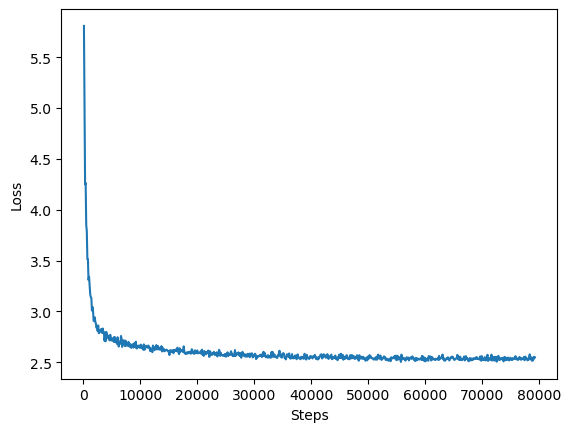

In [4]:
from matplotlib import pyplot as plt
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.plot(steps, loss_list)

In [5]:
torch.save(model.state_dict(), config["saved Encoder path"])